In [16]:
from tqdm import tqdm
tqdm.pandas()
from glob import glob

import json
import csv
import numpy as np
import pandas as pd
from collections import Counter

import rdflib
from rdflib import Graph
from data.data import CollectionAccessor, ImageHandler, EmbeddingSpaceAccessor

from search import Search, Randomiser, GraphSearcher, EmbeddingSearcher

def init_DMG():
    image_folder = "./data/images/DMG"
    image_handler = ImageHandler(image_folder=image_folder, keep_prefix=True)
    print("image paths loaded...")

    time_stamp, pub_file, priv_file = CollectionAccessor.get_latest_dump("./data/dumps")
    # print(CollectionAccessor.get_latest_dump("./data/dumps"))

    
    dmg_meta = dict(name="Design Museum Gent (public & private)", id_="DMG_"+time_stamp,
                creation_timestamp=time_stamp)
    df = CollectionAccessor.get_DMG(pub_path=pub_file, #get_latest("./data/dumps", contains="public"),
                                     priv_path=priv_file, #get_latest("./data/dumps", contains="private"),
                                     rights_path="./data/rights.csv",
                                     image_handler=image_handler,
                                     **dmg_meta)
    return image_handler, df

im, dmg = init_DMG()

image paths loaded...


100%|█████████████████████████████████████████████████████████████████████| 24824/24824 [00:00<00:00, 674208.73it/s]


In [18]:
kg_searcher = GraphSearcher(dmg)
sem_embs = EmbeddingSpaceAccessor.load("data/generated_data/distiluse-base-multilingual-cased-v2",
                                       loadXD=13)
sem_searcher = EmbeddingSearcher(sem_embs, name="SemanticSearcher")
    
viz_embs = EmbeddingSpaceAccessor.load("data/generated_data/vitmae", loadXD=13)
viz_searcher = EmbeddingSearcher(viz_embs, name="VisualSearcher")

s = Search([kg_searcher, sem_searcher, viz_searcher])

[GraphSearcher]: building graph...: 100%|███████████████████████████████████| 24824/24824 [00:05<00:00, 4684.80it/s]


In [48]:
searcher_ids = [searcher.id for searcher in s.searchers]
cur_searchers = [s for s in s.searchers for s_id in searcher_ids if s.id == s_id]

cur_searchers

In [45]:
recs = dmg.sample(4)
cur_searchers = s.searchers

searcher_scores = [s(recs) for s in []]# self.searchers]
searcher_scores = pd.DataFrame({s.name: s for s in searcher_scores})
searcher_scores.loc[recs.index] = 0.


KeyError: "None of [Index(['2002-0023_4-7', '2005-0012_0-3', '1995-0030_4-5', '2009-0075_3-5'], dtype='object', name='object_number')] are in the [index]"

<Axes: >

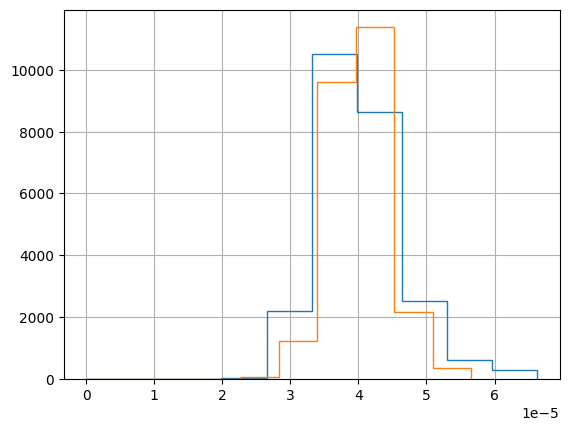

In [43]:
def unit_norm(scores):
    return scores/scores.sum()

normed_scores = (searcher_scores/searcher_scores.sum(0))

# 1/len(searcher_scores)


normed_scores.mean(axis=1).hist(histtype="step")
unit_norm(searcher_scores.mean(axis=1)).hist(histtype="step")

In [ ]:
pd.Series([v for _ in tqdm(range(50)) for v in kg(dmg.sample(6))]).value_counts().sort_index()

---

In [ ]:
import networkx as nx
class GraphSearcher():#Searcher):
    @staticmethod
    def iter_values(r):
        for v in r:
            if isinstance(v, list): yield from v
            elif v: yield v
            else: pass
    
    def _build(self, collection):
        # pbar = tqdm(collection[self.cats].iterrows(), 
        #             total=len(collection), desc='[GraphSearcher]: building graph...')
        pbar = collection[self.cats].iterrows()
        cat_obj_links = [(r.name, v) for i, r in pbar for v in GraphSearcher.iter_values(r)]
        
        # pbar = tqdm(collection[self.cats].iterrows(), 
        #             total=len(collection), desc='[GraphSearcher]: building graph...')
        pbar = collection[self.cats].iterrows()
        cat_cat_links = [tuple(sorted((v1, v2)))for i, r in pbar 
                         for v1 in GraphSearcher.iter_values(r) for v2 in GraphSearcher.iter_values(r) 
                         if (v1 and v2) and (not v1 == v2)]
        return nx.from_edgelist(cat_obj_links+list(set(cat_cat_links)))
    
    def __init__(self, coll, cats=None, name="KGSearcher"):
        # super().__init__(name)    
        
        self.obj_nodes = set(coll.index)
        self.cats = cats if (cats is not None) else coll.coll.categorical_cols.keys()
        self.G = self._build(coll)
        self.id = "KG"

    
    def __call__(self, records):
        assert all((obj_num in self.obj_nodes) for obj_num in records.index)
        
        dists = [nx.shortest_path_length(self.G, source=objnum, target=None) for objnum in records.index]

        raw_scores = pd.Series([np.mean([(d[obj_num] if obj_num in d else 100) for d in dists]) 
                                for obj_num in self.obj_nodes], 
                       index=self.obj_nodes, name=self.id)
        return raw_scores #self.dist2sim(raw_scores)

    @staticmethod
    def unit_norm(s):
        unit_normed = (s - s.min())/(s.max()- s.min())
        return unit_normed #/unit_normed.sum()

    @staticmethod
    def dist2sim(d):
        return GraphSearcher.unit_norm(d.max() - d)


In [ ]:
cs = ['objectname_URI', 'material_URI', 'part_label', 'part_material_URI', 'maker_URI', 'coiner_URI']
kg = GraphSearcher(dmg, cats=cs)
kg(dmg.sample(6)).value_counts()

In [ ]:
from itertools import combinations
len(list(combinations(range(10), 7)))

In [ ]:
from itertools import combinations
combs = combinations(dmg.coll.categorical_cols.keys(), 7)
for cur_cs in tqdm(combs):
    print(cur_cs)
    kg = GraphSearcher(dmg, cats=list(cur_cs))
    

    vals = kg(dmg.sample(6)).value_counts()
    if len(vals) > 4 and vals.iloc[0] < 12000:
        print(cur_cs)
        print(vals, "\n\n\n")

In [ ]:
pbar = tqdm(dmg[dmg.coll.categorical_cols.keys()].iterrows(), 
                    total=len(dmg), desc='[GraphSearcher]: building graph...')
cat_obj_links = [(r.name, v) for i, r in pbar for v in GraphSearcher.iter_values(r) if v]

In [ ]:
# len(cat_obj_links), cat_obj_links[:10]

len(kg.G.nodes)

In [ ]:
for c in dmg.coll.categorical_cols.keys():
    print(c)
    print(pd.Series(
        [v for row in dmg[c] for v in (row if isinstance(row, list) else [row]) if v]
    ).value_counts().iloc[:3])
    print("\n\n")

---
# EMBEDDINGS

In [ ]:
# from data import EmbeddingSpaceAccessor
# import umap.umap_ as umap

# sem_emb_dir = "./distiluse-base-multilingual-cased-v2_embeddings/"
# sem_emb = EmbeddingSpaceAccessor.load(sem_emb_dir, loadXD=None, index_col="record_id", )

# n_c = 32
# reducer = umap.UMAP(metric="cosine", n_neighbors=10, min_dist=(sem_emb.values.var()**0.5/2), n_components=n_c)
# red_embs = pd.DataFrame(reducer.fit_transform(sem_emb.to_numpy()), index=sem_emb.index)
# red_embs.to_csv(f"{sem_emb_dir}/embs_umap_{n_c}D.csv")

In [ ]:
vis_embs = EmbeddingSpaceAccessor.load("./data/generated_data/vitmae")

In [ ]:
vis_embs

In [ ]:
red_embs = vis_embs.emb_space.umap(save_to="./data/generated_data/vitmae/embeddings_32.csv")

In [ ]:
from search import EmbeddingSearcher


vs = EmbeddingSearcher(red_embs, name="VisualSearcher")

In [ ]:
vs(dmg.sample(4)).hist()

In [ ]:
# import umap.umap_ as umap

# k = -1
# data = vis_embs.iloc[:k].to_numpy()
# default_params = dict(metric="cosine", n_neighbors=10, 
#                     min_dist=(data.var()**0.5/5), spread=40, n_components=2)

# print(default_params["min_dist"])
# # default_params.update(umap_params)
# reducer = umap.UMAP(**default_params)
# red_embs = pd.DataFrame(reducer.fit_transform(data), index=vis_embs.index[:k])
# # if save_to is not None:
# #     red_embs.to_csv(save_to, index=True, sep=("\t" if to_tsv else ","))


In [ ]:
import matplotlib.pyplot as plt

plt.plot(red_embs.values.T[0], red_embs.values.T[1], ".")

### semantic embeddings

In [ ]:
sem_embs = EmbeddingSpaceAccessor.load("./data/generated_data/distiluse-base-multilingual-cased-v2/")

In [ ]:
red_embs = sem_embs.emb_space.umap(save_to="./data/generated_data/distiluse-base-multilingual-cased-v2/embeddings_32.csv")

---
# concept search

In [2]:
from search import TextEmbeddingSearcher

In [3]:
sem_embs = EmbeddingSpaceAccessor.load("data/generated_data/distiluse-base-multilingual-cased-v2/",
                                       loadXD=None)

In [4]:
ts = TextEmbeddingSearcher(sem_embs)

/home/valentin/home2-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [24]:
dmg.loc[ts("stoel met rugleuning").sort_values()[::-1].index[:20]].coll.get_texts()

object_number
2008-0151                      Eikenhouten stoel met smalle rugleuning
2011-0055                                                 Tivoli chair
1986-0054_06-10                             stoel uit eetkamerensemble
1986-0054_04-10                             stoel uit eetkamerensemble
1986-0054_03-10                             stoel uit eetkamerensemble
1986-0054_02-10                             stoel uit eetkamerensemble
1986-0054_01-10                             stoel uit eetkamerensemble
2016-0004_1-2                                                   chaise
1995-0006_ARCHIEF                                                stoel
1834                                    Rieten 'fauteuil en cabriolet'
2010-0008                                                 Bronto chair
3691                                                Poot van een zetel
1999-0073                                                 Oyster chair
1996-0021                                                 T-bOn

In [ ]:
import torch
vec = ts.embedder.encode("serendipity")
vec = torch.as_tensor(vec).double()
sims = pd.Series(ts.rank_vector(vec), index=ts.space.index, name=ts.id)
sims.sort_values()[::-1][:100]

In [ ]:
dmg.loc[sims.sort_values()[::-1].index[:100]].coll.get_texts()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(
    list(sims.sort_values()[::-1]),
    dmg.coll.get_texts().apply(len).loc[sims.sort_values()[::-1].index],
    "."
)